# Spherical Rotation of Iris Dataset

## Import Modules

In [17]:
# standard library
from itertools import combinations


# 3rd party libraries
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.interpolate as interp
from sklearn.datasets import load_iris
from sklearn.model_selection import ParameterGrid
import tensorflow as tf
import tqdm

# conaction library
from conaction.estimators import pearson_correlation
from conaction.transform import HypersphericalRotation

# Iris Dataset

In [2]:
data_dict = load_iris(as_frame=True)
y = [data_dict['target_names'][i] for i in data_dict['target'].to_numpy()]
df1 = data_dict['data']
df1['species'] = y
df1.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [3]:
# Prepare data for Tensorflow
x = data_dict['data'].to_numpy()[:,:-1]
x = tf.constant(x, dtype=tf.float64)

2022-01-27 08:50:13.865232: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-27 08:50:13.868178: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Prepare Hyperspherical Rotation Model

In [5]:
# Instantiate object
model = HypersphericalRotation()

In [6]:
# Set the initial angles of the data points (and their magnitudes)
model.set_angles(x)

## Define a loss function

Here we have chosen a loss function to be the following:

$$\mathcal{L}\left( S \right) = \sum_{\substack{s \in \mathcal{P}(S) \\ |s| \not\in \{0, 1 \}}} R(s)^2$$

where $S = \{X_1, \cdots, X_n \}$ and $R$ represents the multilinear Pearson correlation coefficient defined as

$$R(X_1, \cdots, X_n) \triangleq \frac{\mathbb{E}\left[ \prod_{j=1}^{n} \left(X_j - \mathbb{E}\left[ X_j \right] \right) \right]}{\prod_{j=1}^{n} \sqrt[n]{\mathbb{E}\left[ |X_j - \mathbb{E}\left[ X_j \right]|^n\right]}}$$

In [8]:
def loss(X):
    '''
    Sums of squares of the multilinear Pearson correlation coefficients for every set of variables in the powerset 
    of variables excluding the empty set and sets of unit cardinality.
    
    Parameters
    ----------
    X : tf.tensor
        Data matrix
    
    Returns
    -------
    result : tf.float
        Multilinear correlation loss
    '''
    result = 0
    for size in range(2, X.shape[1]+1):
        for comb in combinations(range(X.shape[1]), size):
            X_sub = tf.transpose(tf.stack([X[:, i] for i in comb]))
            result += pearson_correlation(X_sub)**2
    return result

## Gridsearch Over Two Parameters

In [21]:
history = []
n = 50
for t1 in tqdm.tqdm(np.linspace(0, 2 * np.pi, num=n)):
    for t2 in np.linspace(0, 2 * np.pi, num=n):
        model.tau = tf.constant([t1, t2] + [0] * int(x.shape[1]-3))
        history.append([t1, t2, loss(model(x))])

history = np.array(history)
X, Y, Z = history.T

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.28it/s]


## Plot Surface and Contours of Loss Surface

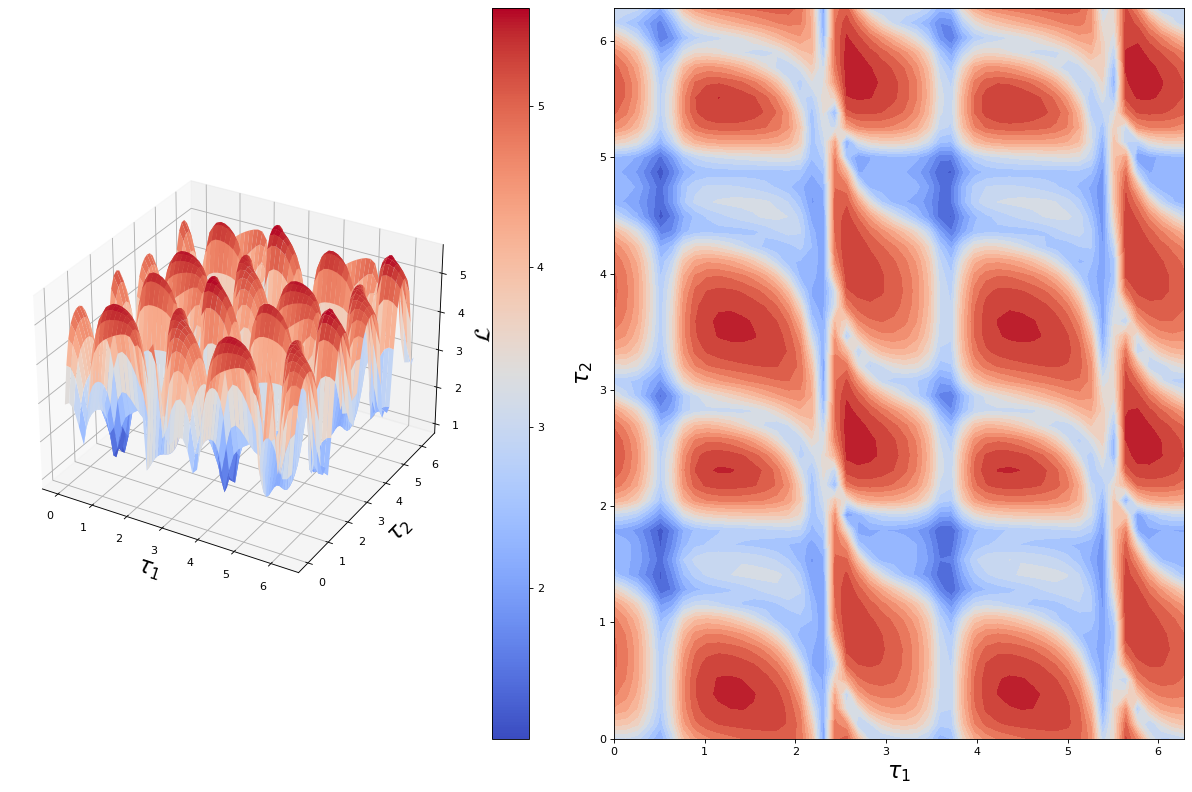

In [30]:
plotx, ploty, = np.meshgrid(np.linspace(np.min(X),np.max(X),n),\
                       np.linspace(np.min(Y),np.max(Y),n))

plotz = interp.griddata((X,Y),Z,(plotx,ploty), method='cubic')

fig = plt.figure(figsize=(15, 10), dpi=80)

ax1 = fig.add_subplot(121, projection='3d')

surface_plot = ax1.plot_surface(plotx, ploty, plotz, cmap='coolwarm')

ax1.set_xlabel('$\\tau_1$', fontsize=20)

ax1.set_ylabel('$\\tau_2$', fontsize=20)

ax1.set_zlabel('$\\mathcal{L}$', fontsize=20)

ax2 = fig.add_subplot(122)

contour_plot = ax2.contourf(plotx, ploty, plotz, levels=20, cmap='coolwarm')

ax2.set_xlabel('$\\tau_1$', fontsize=20)

ax2.set_ylabel('$\\tau_2$', fontsize=20)

fig.colorbar(surface_plot, ax=ax1)

plt.tight_layout()

plt.show()

## The Optimal Rotations

In [27]:
index_min = np.argmin(Z)
index_max = np.argmax(Z)

tau_min = tf.constant([X[index_min], Y[index_min]])
tau_max = tf.constant([X[index_max], Y[index_max]])

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.16326531, 1.55102041])>

In [ ]:
##tol = 1e-6
##best_loss = np.inf
##best_params = {}
##param_grid = {i:np.linspace(0, 2*np.pi,num=10) for i in range(x.shape[1]-1)}
##
##for grid in ParameterGrid(param_grid):
##    point = [i for i in grid.values()]
##    model.tau = tf.constant(point, dtype=tf.float64)
##    if loss(model(x).numpy()) < best_loss:
##        best_loss = loss(model(x).numpy())
##        best_params = point
##        print(point, loss(model(x).numpy()))
##model.tau = tf.constant(best_params, dtype=tf.float64)
##
##df2 = pd.DataFrame(model(x).numpy())
##df2['species'] = y
##df2 = df2.rename(columns={i:f'Rot({j})' for i,j in zip(range(5), df1.columns)})
##
##sns.pairplot(df1, hue='species')
##sns.pairplot(df2, hue='species')
##plt.show()
    
    
##    plt.plot(history.history['loss'])
##    plt.show()
##    plt.close()
##    for t in weights.T:
##        plt.plot(t)
##        plt.show()
##        plt.close()